# FF model


## Settings

In [1]:
base = "data"
dataset = "nist"
kind = "de_novo"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"


%load_ext autoreload
%autoreload 2

## Data loading

In [3]:
# from matchms.importing import load_from_msp


from helpers import get_mz_vector, get_his_size
from data_utils import spectrum_processing
from data_utils import FixedSizeDS
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F

# only for visual 
from spec2vec import SpectrumDocument
from data_utils import BasicCoder


In [4]:
def get_spectra(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s, min_rel_int=None) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    return spectrums

spectrums_train = get_spectra(data_train_path)
spectrums_val = get_spectra(data_val_path)
spectrums_test = get_spectra(data_test_path)

In [73]:
documents_val = [SpectrumDocument(s, n_decimals=0) for s in spectrums_val]
documents_test = [SpectrumDocument(s, n_decimals=0) for s in spectrums_test]

In [46]:
datasets = {
    "fixed_train": FixedSizeDS(spectrums_train), 
    "fixed_val": FixedSizeDS(spectrums_val), 
    "fixed_test": FixedSizeDS(spectrums_test)
}

dataloaders = {
    "train": DataLoader(datasets["fixed_train"], batch_size=1024, shuffle=True, num_workers=8),
    "val": DataLoader(datasets["fixed_val"], batch_size=1024, shuffle=True, num_workers=8),
    "test": None
}

In [7]:
datasets["fixed_train"][0][1].sum()

tensor(1.)

## Models definition

In [22]:
class Linear(nn.Module):
    def __init__(self, max_mz=1001):
        super(Linear, self).__init__()
        self.in_features = max_mz
        self.out_features = max_mz
    
        self.linear = nn.Linear(self.in_features, self.out_features)
        self.sigm = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear(x)
        return self.sigm(x)
    
class MLP(nn.Module):
    def __init__(self, max_mz=1001, hidden_layers=(2000,)):
        super(MLP, self).__init__()
        self.in_features = max_mz
        self.out_features = max_mz
        
        assert len(hidden_layers) != 0
        self.relu = nn.ReLU()        
        layers = [nn.Linear(self.in_features, hidden_layers[0])]
        
        for i in range(len(hidden_layers)-1):
            layers.append(self.relu)
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            
        
        self.layers = nn.Sequential(*layers)
        self.linear = nn.Linear(hidden_layers[-1], self.out_features)
        self.sigm = nn.Sigmoid()

        
    def forward(self, x):
        x = self.layers(x)
        x= self.relu(x)
        x = self.linear(x)
        return self.sigm(x)
    

In [54]:
linear = Linear(datasets["fixed_train"].max_mz)
mlp_1 = MLP(datasets["fixed_train"].max_mz, (1000,))
mlp_2 = MLP(datasets["fixed_train"].max_mz, (1000,1000))
mlp_3 = MLP(datasets["fixed_train"].max_mz, (1000,1000, 1000))
mlp_1s = MLP(datasets["fixed_train"].max_mz, (500,))
mlp_2s = MLP(datasets["fixed_train"].max_mz, (500,500))
mlp_3s = MLP(datasets["fixed_train"].max_mz, (500,500, 500))



## Training


In [24]:
class Learner():
    def __init__(self, train_loader, val_loader, model, optimizer, loss_fn, \
                 device, model_name="model"):
        self.train_loader= train_loader
        self.val_loader = val_loader
        self.model = model 
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.model_name=model_name
        self.train_losses = []
        self.val_losses = []
        
        
    def evaluate(self, loader):
        eval_loss = 0
        self.model.eval()
        self.model.to(self.device)
        for b, (X, y) in enumerate(loader):
            with torch.no_grad():
                
                X, y = X.to(device), y.to(device)
                pred = self.model(X)
                
                loss = self.loss_fn(pred, y)
                eval_loss += loss.item()
            
        eval_loss /= len(loader)
        
        return eval_loss
    
    def train(self,n_epochs, early_stopping=True, patience=3, verbose=False):
        self.model.to(self.device)

        if early_stopping:
            min_val_loss = np.inf
            no_improve = 0
        
        
        e_bar = tqdm.tqdm(range(n_epochs), total=n_epochs, leave=True, desc="Epoch: ")
        for e in e_bar:
            # train
            train_loss = 0
            self.model.train()
            for b, (X, y) in enumerate(self.train_loader):
                X, y = X.to(device), y.to(device)
                # zero the parameter gradients
                self.optimizer.zero_grad()

                pred = self.model(X)
                
                loss = self.loss_fn(pred, y)
                loss.backward()

                self.optimizer.step()

                if verbose and b % (len(self.train_loader)//100) == 0:
                    print(f"Done: {b}/{len(self.train_loader)}")
            
            # evaluate (train, validation)
            train_loss = self.evaluate(self.train_loader)
            val_loss = self.evaluate(self.val_loader)

            # early stopping
            if early_stopping:
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    torch.save(self.model, f"models/{kind}/{self.model_name}")
                    no_improve = 0
                else:
                    no_improve += 1
            if no_improve > patience:
                print("Early stopped")
                self.model = torch.load(f"models/{kind}/{self.model_name}")
                break
            
            #print(f"After {e+1} epochs: ")
            e_bar.set_postfix({'Train loss': f"{train_loss:.3}",'Val loss': f"{val_loss:.3}" })
            #print(f"Train loss: {train_loss:.3}")
            #print(f"Val loss: {val_loss:.3}\n")
                
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            np.save(f"losses/{kind}/{self.model_name}_train_loss.npy", self.train_losses)
            np.save(f"losses/{kind}/{self.model_name}_val_loss.npy", self.val_losses)

        np.save(f"losses/{kind}/{self.model_name}_train_loss.npy", self.train_losses)
        np.save(f"losses/{kind}/{self.model_name}_val_loss.npy", self.val_losses)
        
        return self.train_losses, self.val_losses
    

In [25]:
# discver whether to use GPU or not
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(device)


cuda


In [26]:
from visual_utils import plot_training
def train(model, train_loader, val_loader, model_name, lr=1e-3, \
          patience=10, max_epoch=500, device="cpu"):
    
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss(reduction="mean")

    # # init weights
    # for name, param in model.named_parameters():
    #     if "bias" in name:
    #         nn.init.constant_(param, 0.0)
    #     else:
    #         nn.init.xavier_normal_(param)
    
    learner = Learner(train_loader, val_loader, model, optim, loss_fn, device, model_name)
    train_losses, val_losses = learner.train(max_epoch, patience)
    plot_training(learner)
    model.to("cpu")
    return train_losses, val_losses

In [13]:
pytorch_total_params = sum(p.numel() for p in linear.parameters() if p.requires_grad)

print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 1M


Epoch:  12%|█▏        | 59/500 [29:24<3:39:50, 29.91s/it, Train loss=0.00727, Val loss=0.00735]

Early stopped


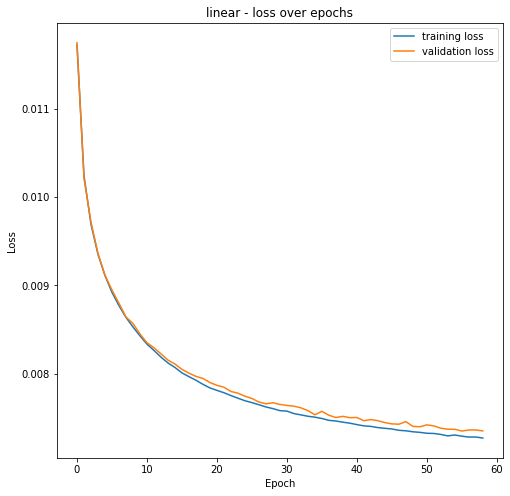

In [21]:
train_losses, val_losses = train(linear, dataloaders["train"], dataloaders["val"], "linear",\
                                 lr=1e-2, patience=10, max_epoch=500, device=device)

In [27]:
pytorch_total_params = sum(p.numel() for p in mlp_1.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 2M


Epoch:  25%|██▌       | 127/500 [44:42<2:11:18, 21.12s/it, Train loss=0.00563, Val loss=0.00578]

Early stopped


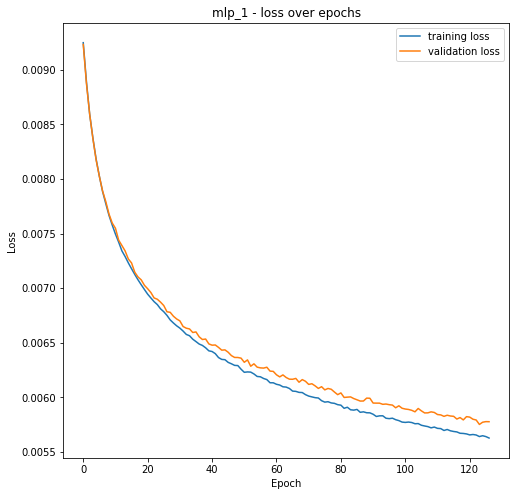

In [29]:
train_losses, val_losses = train(mlp_1, dataloaders["train"], dataloaders["val"], "mlp_1",\
                                 lr=1e-3, patience=10, max_epoch=500, device=device)

In [30]:
pytorch_total_params = sum(p.numel() for p in mlp_2.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 3M


Epoch:  23%|██▎       | 114/500 [37:06<2:05:40, 19.53s/it, Train loss=0.0049, Val loss=0.00512] 

Early stopped


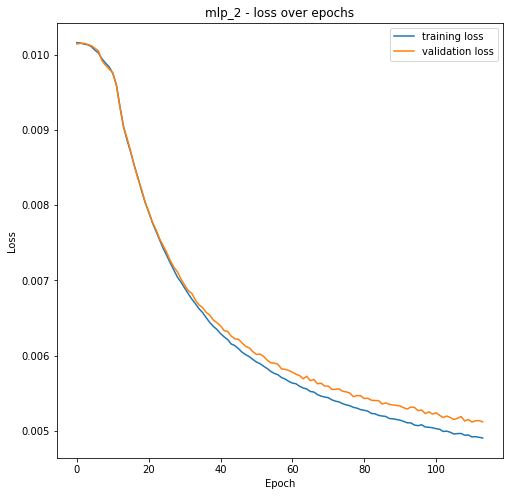

In [31]:
train_losses, val_losses = train(mlp_2, dataloaders["train"], dataloaders["val"], "mlp_2",\
                                 lr=1e-3, patience=10, max_epoch=500, device=device)

In [55]:
pytorch_total_params = sum(p.numel() for p in mlp_3.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 4M


Epoch:   1%|          | 5/500 [01:52<3:05:40, 22.51s/it, Train loss=0.0102, Val loss=0.0102]

Early stopped


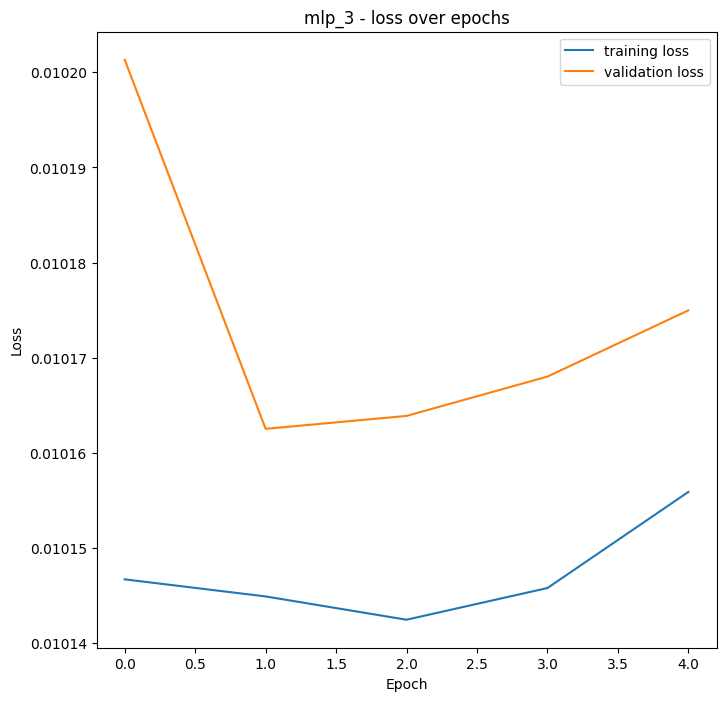

In [56]:
train_losses, val_losses = train(mlp_3, dataloaders["train"], dataloaders["val"], "mlp_3",\
                                 lr=5e-4, patience=10, max_epoch=500, device=device)

In [34]:
pytorch_total_params = sum(p.numel() for p in mlp_1s.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 1M


Epoch:  33%|███▎      | 167/500 [52:17<1:44:16, 18.79s/it, Train loss=0.00614, Val loss=0.00623]

Early stopped


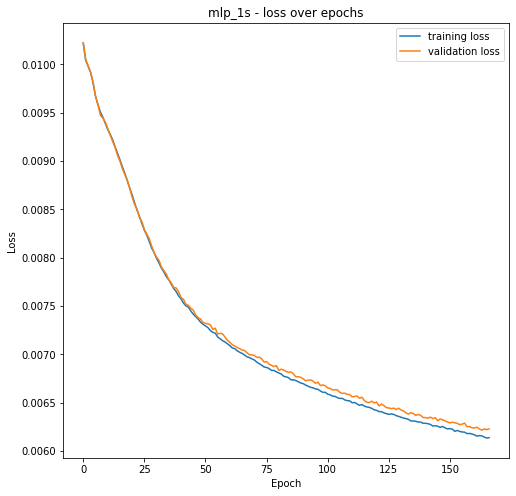

In [35]:
train_losses, val_losses = train(mlp_1s, dataloaders["train"], dataloaders["val"], "mlp_1s",\
                                 lr=1e-3, patience=10, max_epoch=500, device=device)

In [36]:
pytorch_total_params = sum(p.numel() for p in mlp_2s.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 1M


Epoch:  28%|██▊       | 141/500 [43:33<1:50:55, 18.54s/it, Train loss=0.00535, Val loss=0.00547]

Early stopped


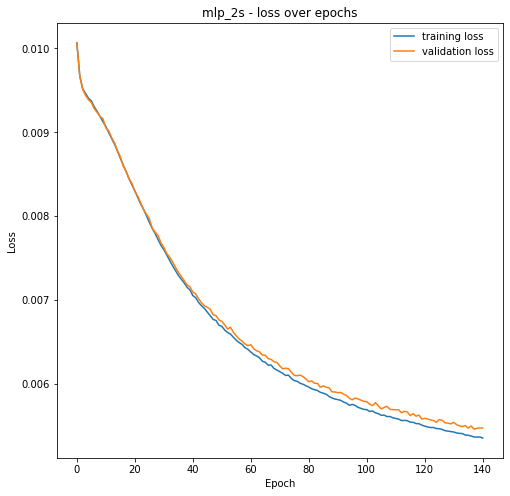

In [37]:
train_losses, val_losses = train(mlp_2s, dataloaders["train"], dataloaders["val"], "mlp_2s",\
                                 lr=1e-3, patience=10, max_epoch=500, device=device)

In [38]:
pytorch_total_params = sum(p.numel() for p in mlp_3s.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 1M


Epoch:   1%|▏         | 7/500 [02:27<2:52:50, 21.04s/it, Train loss=0.0102, Val loss=0.0102]

Early stopped


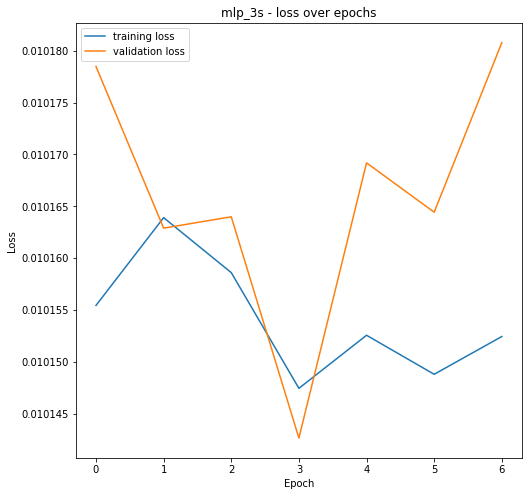

In [39]:
train_losses, val_losses = train(mlp_3s, dataloaders["train"], dataloaders["val"], "mlp_3s",\
                                 lr=1e-3, patience=10, max_epoch=500, device=device)

## Prediction

In [40]:
class PredictorFF():
    def __init__(self,model, max_mz=1001, threshold=.5):
        self.model = model
        self.max_mz= max_mz
        self.threshold = threshold
        
    @classmethod
    def from_file(cls, file, device="cpu", max_mz=1001, threshold=.5):
        model = torch.load(file,  map_location=torch.device(device)) 
        return cls(model, max_mz=max_mz, threshold=threshold)
   

    def __call__(self, X):
        with torch.no_grad():
            return self.model(X)
    
    def predict_random_all(self, ds, probs, cum_level=.95, filtered=True, \
                           device="cpu", **kwargs):
        # reset rng before each prediction to have comparable results
        self.rng = np.random.default_rng(42)

        spectrums = ds.spectrums
        m_pred_per_p = [[None for _ in range(len(spectrums))] for _ in range(len(probs))]
        m_y_per_p = [[None for _ in range(len(spectrums))] for _ in range(len(probs))]
        some_pred_per_p = [[None for _ in range(len(spectrums))] for _ in range(len(probs))]
        
        for i, spec in enumerate(spectrums):
            vect = get_mz_vector(spec, self.max_mz)
            
            mat = np.zeros(shape=(len(probs),vect.shape[0]), dtype=np.float32)

            # descending = np.argsort(spec.peaks.intensities)[::-1]
            
            # argsorted = np.argsort(vect)[::-1]
            his_size = get_his_size(spec, cum_level)
            his_ind = np.argpartition(vect, -his_size)[-his_size:]
       
            for m, p in enumerate(probs):
                
                ## cripple vector
                mat[m] = vect.copy()
                
                # if too little peaks are present in the high intensity section, simply cut out top m most intense peaks 
                # cut_out_kths = self.rng.choice(max(n_peaks_considered, m), size=m, replace=False)
                #cut_out_kths = self.rng.choice(n_peaks_considered, size=min(m, n_peaks_considered), replace=False)
                
                # his_ind = np.argsort(mat[m])[::-1][:his_size]
                mask_missing = self.rng.uniform(0,1, self.max_mz) < p
                
                #cut_out_indices = argsorted[his_ind[mask_missing]] 
                
                mat[m][mask_missing] = 0
                
                his_mask = np.zeros_like(vect) == 1
                his_mask[his_ind] = True
                
                m_y_per_p[m][i] = np.where(mask_missing & his_mask)[0]
                
            # get predictions
            with torch.no_grad():
                mat_ = torch.from_numpy(mat).to(device)
                pred = self.model(mat_)
                pred = pred.cpu().numpy()    
            
            if filtered:
                pred[mat!=0] = 0
                
            # get best peaks above threshold (except the given ones)    
            for m in range(len(probs)):
                some = np.where(pred[m] > self.threshold)[0]
                some_pred_per_p[m][i] = some
            
            # get best m peaks (except the given ones)
            for m in range(len(probs)):
                next_m = np.argsort(pred[m])[::-1][:len(m_y_per_p[m][i])]
                m_pred_per_p[m][i] = next_m     
            
        return some_pred_per_p, m_pred_per_p, m_y_per_p



# Linear

## Visualisation

In [49]:
from visual_utils import plot_spectrum_predictions_random
from matplotlib.pyplot import savefig
predictor = PredictorFF.from_file(f"models/{kind}/linear", max_mz=1001)
predictor.model.cpu()

Linear(
  (linear): Linear(in_features=1001, out_features=1001, bias=True)
  (sigm): Sigmoid()
)

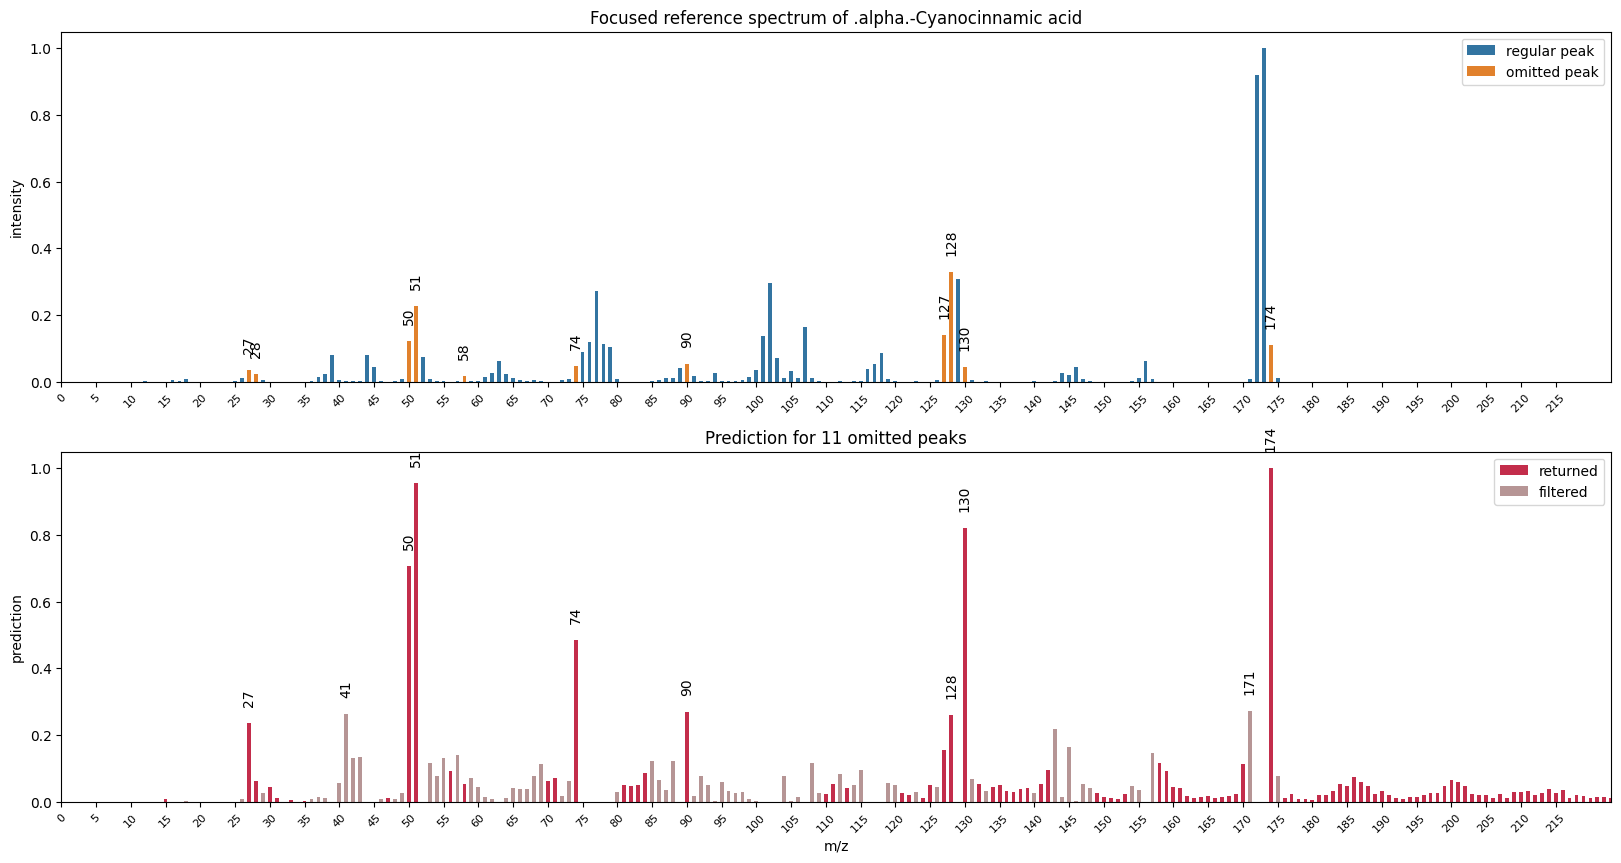

In [50]:
i  = 4444
datasets["fixed_val"].reset_rng(42)
X, y = datasets["fixed_val"][i]
pred = predictor(X).cpu().numpy()
plot_spectrum_predictions_random(documents_val[i], np.where(y!=0)[0], pred, \
                                 BasicCoder(max_mz=predictor.max_mz), plot_full=False, \
                                 save_to_path=f"figures/{kind}/visual/linear_val.pdf")


## Model Selection
done on the val set

In [180]:
P_FOLDER = f"predictions/{kind}"
probs = [0, .01, .03, .05, .08, .1, .15, .2, .3, .5]

In [164]:
import os
from metrics import metrics_klj, metrics_intlj

predictors = { 
            "linear_.8": PredictorFF.from_file(f"models/{kind}/linear", max_mz=1001, device=device, threshold=.8),
            "linear_.5": PredictorFF.from_file(f"models/{kind}/linear", max_mz=1001, device=device, threshold=.5),
            "linear_.3": PredictorFF.from_file(f"models/{kind}/linear", max_mz=1001, device=device, threshold=.3),
            "linear_.1": PredictorFF.from_file(f"models/{kind}/linear", max_mz=1001, device=device, threshold=.1)
}


In [165]:
P_FOLDER

'predictions/de_novo'

In [166]:
from model_evaluation import calc_predictions_random, load_predictions_random, model_selection_random
from visual_utils import plot_scores

In [241]:
%%time
calc_predictions_random(probs, predictors, datasets, "fixed_val", P_FOLDER, batch_size=512, device=device, verbose=True)

linear_.8


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


linear_.5
linear_.3
linear_.1
CPU times: user 2min 29s, sys: 2.74 s, total: 2min 32s
Wall time: 2min 33s


In [186]:
best_p_name, scores = model_selection_random(P_FOLDER, "fixed_val", predictors=predictors)

linear_.3


/mnt/storage-brno6/home/xstary1/raims/metrics.py:200: RuntimeWarning: Mean of empty slice
  mean_rec_some = np.nanmean(recs_some, axis=1)
/mnt/storage-brno6/home/xstary1/raims/metrics.py:202: RuntimeWarning: Mean of empty slice
  mean_f1_some = np.nanmean(f1_some, axis=1)
/mnt/storage-brno6/home/xstary1/raims/metrics.py:203: RuntimeWarning: Mean of empty slice
  mean_prec= np.nanmean(precs_m, axis=1)


linear_.8
linear_.5
linear_.1


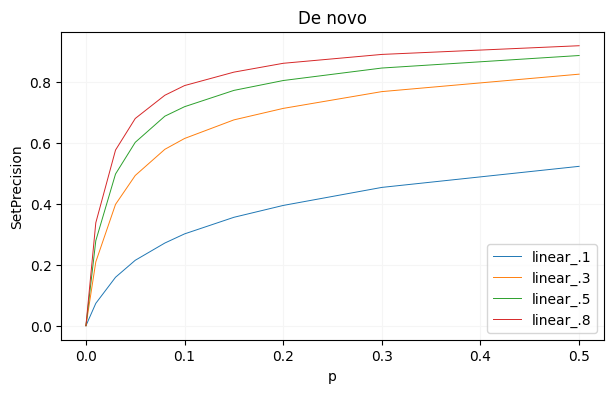

In [187]:
orderer_f = lambda x: (x.split("_")[1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[1][1]))
plot_scores(scores, metrics="mp", x=probs,
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanPrecision",
            save_to_path=f"figures/{kind}/selection/lr_val_prec.pdf")

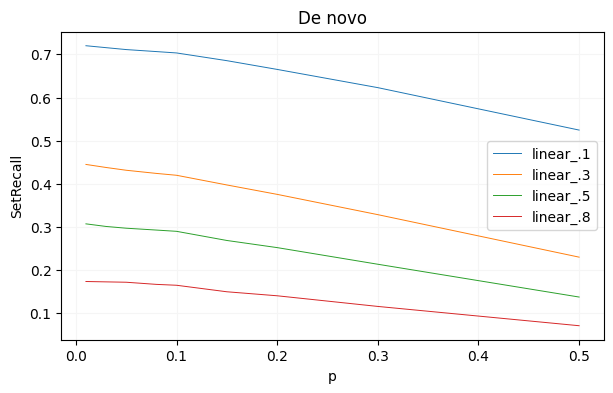

In [188]:
plot_scores(scores, metrics="mr", x=probs,
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanRecall",
            save_to_path=f"figures/{kind}/selection/lr_val_rec.pdf")

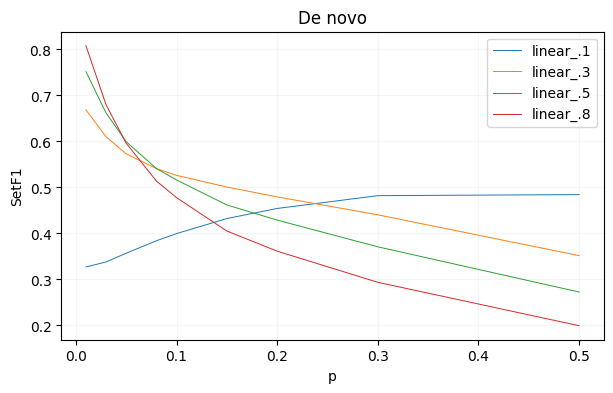

In [189]:
plot_scores(scores, metrics="mf1", x=probs,
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1",
            save_to_path=f"figures/{kind}/selection/lr_val_f1.pdf")

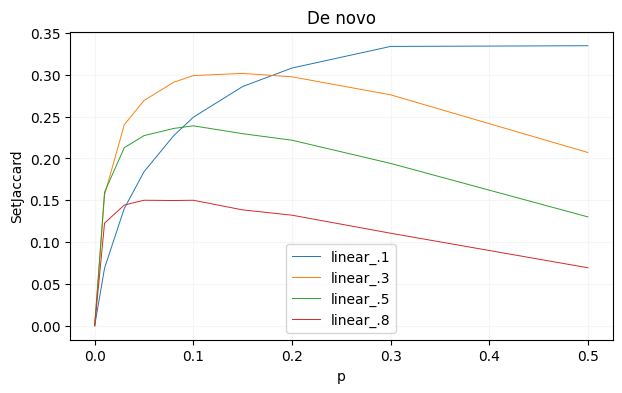

In [190]:
plot_scores(scores, metrics="mj", x=probs,
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanJaccard",
            save_to_path=f"figures/{kind}/selection/lr_val_jac.pdf")

In [191]:
scores

{'linear_.3': {'mpm': array([       nan, 0.45527989, 0.47471753, 0.48761791, 0.50767687,
         0.51749115, 0.53014891, 0.53639223, 0.54347859, 0.52982151]),
  'mp': array([0.        , 0.20924557, 0.39786302, 0.49258045, 0.57831869,
         0.61386024, 0.67480663, 0.71244297, 0.76750348, 0.82466594]),
  'mr': array([       nan, 0.44492529, 0.43786349, 0.43144543, 0.42411317,
         0.41981172, 0.39737067, 0.37557385, 0.3285658 , 0.23008644]),
  'mf1': array([       nan, 0.66866772, 0.61024595, 0.57307067, 0.54111129,
         0.52632409, 0.5009744 , 0.47957343, 0.44057278, 0.35186332]),
  'mj': array([0.        , 0.15643976, 0.24025133, 0.26923993, 0.29098031,
         0.2990326 , 0.30163679, 0.29756726, 0.27604203, 0.20706913])},
 'linear_.8': {'mpm': array([       nan, 0.45527989, 0.47471753, 0.48761791, 0.50767687,
         0.51749115, 0.53014891, 0.53639223, 0.54347859, 0.52982151]),
  'mp': array([0.        , 0.33754218, 0.57586485, 0.67941679, 0.75555005,
         0.78730406

In [192]:
best_p_name

'linear_.3'

## Visualisation of the best predictor

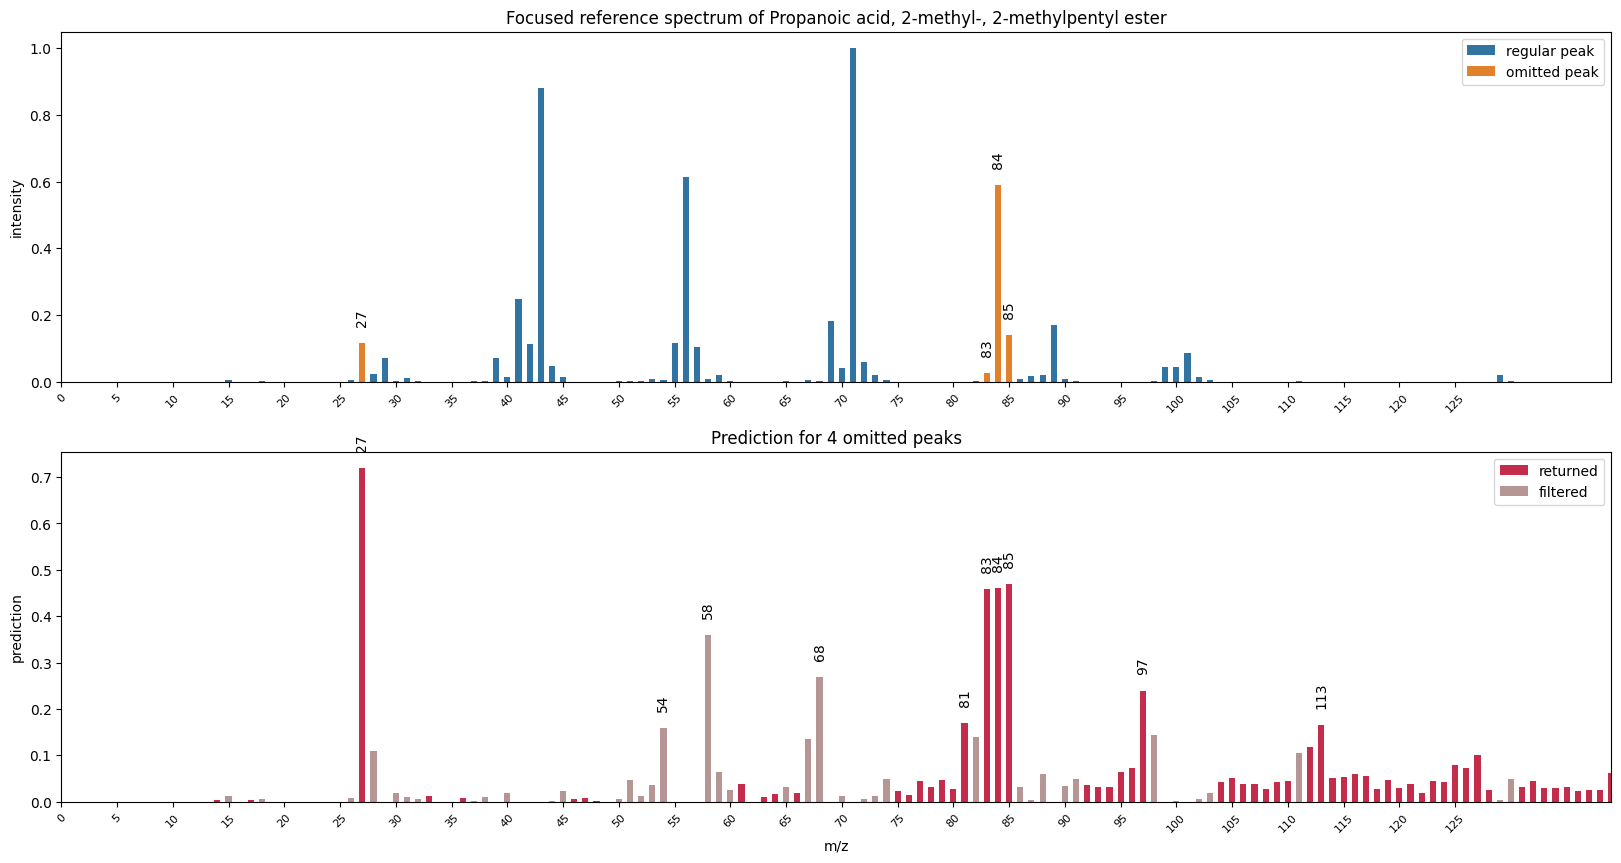

In [193]:
i  = 4444
datasets["fixed_test"].reset_rng(42)
X, y = datasets["fixed_test"][i]
pred = predictors[best_p_name](X.to(device)).cpu().numpy()
plot_spectrum_predictions_random(documents_test[i], np.where(y!=0)[0], pred, BasicCoder(max_mz=predictors[best_p_name].max_mz), plot_full=False)


## Detailed evaluation of the best predictor 
done on the test set

In [ ]:
%%time
up_to_k = 50
l = l
calc_predictions(up_to_k, l, {best_p_name: predictors[best_p_name]}, "hugg_test", P_FOLDER)

In [ ]:
l_pred_indices_per_k_best, y_indices, X_intens = load_predictions(best_p_name, "hugg_test", P_FOLDER)
l_pred_indices_per_k_base, y_indices_base, X_intens_base = load_predictions("base_1", "spec_test", P_FOLDER)

In [ ]:
from metrics import accuracy_at_k
from visual_utils import plot_stats

def get_to_len(xs, len_):
    return [xs[i] if i<len(xs) else 0 for i in range(len_)]

accs_at_k = accuracy_at_k(l_pred_indices_per_k_best, y_indices, up_to_k=None)
accs_at_k_base = get_to_len(accuracy_at_k(l_pred_indices_per_k_base, y_indices_base, up_to_k=None), len(accs_at_k))



plot_stats(accs_at_k, baseline1D=accs_at_k_base, title="Accuracy@k", color="red", ylabel='accuracy', xlabel='k')

In [ ]:
from metrics import accuracy_at_int

accs_at_int = accuracy_at_int(l_pred_indices_per_k_best, y_indices, X_intens)
accs_at_int_base = get_to_len(accuracy_at_int(l_pred_indices_per_k_base, y_indices_base, X_intens_base), len(accs_at_int))

In [ ]:
plot_stats(accs_at_int, baseline1D=accs_at_int_base, title="Accuracy@int", color="red", decreasing=True,  ylabel='accuracy', xlabel='intensity level', x_factor=.01)

In [ ]:
sum(l_pred_indices_per_k_base[30][:,0] != -1)

In [ ]:
to_rel_inten=.2
j=6
l=4
up_to_k=50

In [ ]:
mean_prec, mean_jac, mean_prec_int, mean_jac_int = calc_mean_lj_metrics(l_pred_indices_per_k_best, y_indices, \
                                                                        X_intens, up_to_k=up_to_k, l=l, j=j, \
                                                                        l_rel=None, to_rel_inten=to_rel_inten)

mean_prec_base, mean_jac_base, mean_prec_int_base, mean_jac_int_base = calc_mean_lj_metrics(l_pred_indices_per_k_base, \
                                                                                            y_indices_base, X_intens_base, \
                                                                                            up_to_k=up_to_k, l=l, j=j,\
                                                                                            l_rel=None, to_rel_inten=to_rel_inten)

#mean_prec_base = get_to_len(mean_prec_base, len(mean_prec))
#mean_jac_base = get_to_len(mean_jac_base, len(mean_jac))

In [ ]:
plot_stats(mean_prec, baseline1D=mean_prec_base, title="Mean_Prec", color="green", ylabel='precision', xlabel='k')

In [ ]:
plot_stats(mean_jac, baseline1D=mean_jac_base, title="Mean_Jac", color="blue", ylabel='jaccard', xlabel='k')

In [ ]:
plot_stats(mean_prec_int, baseline1D=mean_prec_int_base, title="Mean_Prec", color="green", ylabel='precision', xlabel='k')

In [ ]:
plot_stats(mean_jac_int, baseline1D=mean_jac_int_base, title="Mean_Jac", color="blue", ylabel='jaccard', xlabel='k')

# MLP

## Visualisation

In [194]:
from visual_utils import plot_spectrum_predictions_random
from matplotlib.pyplot import savefig
predictor = PredictorFF.from_file(f"models/{kind}/mlp_1", max_mz=1001)
predictor.model.cpu()

MLP(
  (relu): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=1001, out_features=1000, bias=True)
  )
  (linear): Linear(in_features=1000, out_features=1001, bias=True)
  (sigm): Sigmoid()
)

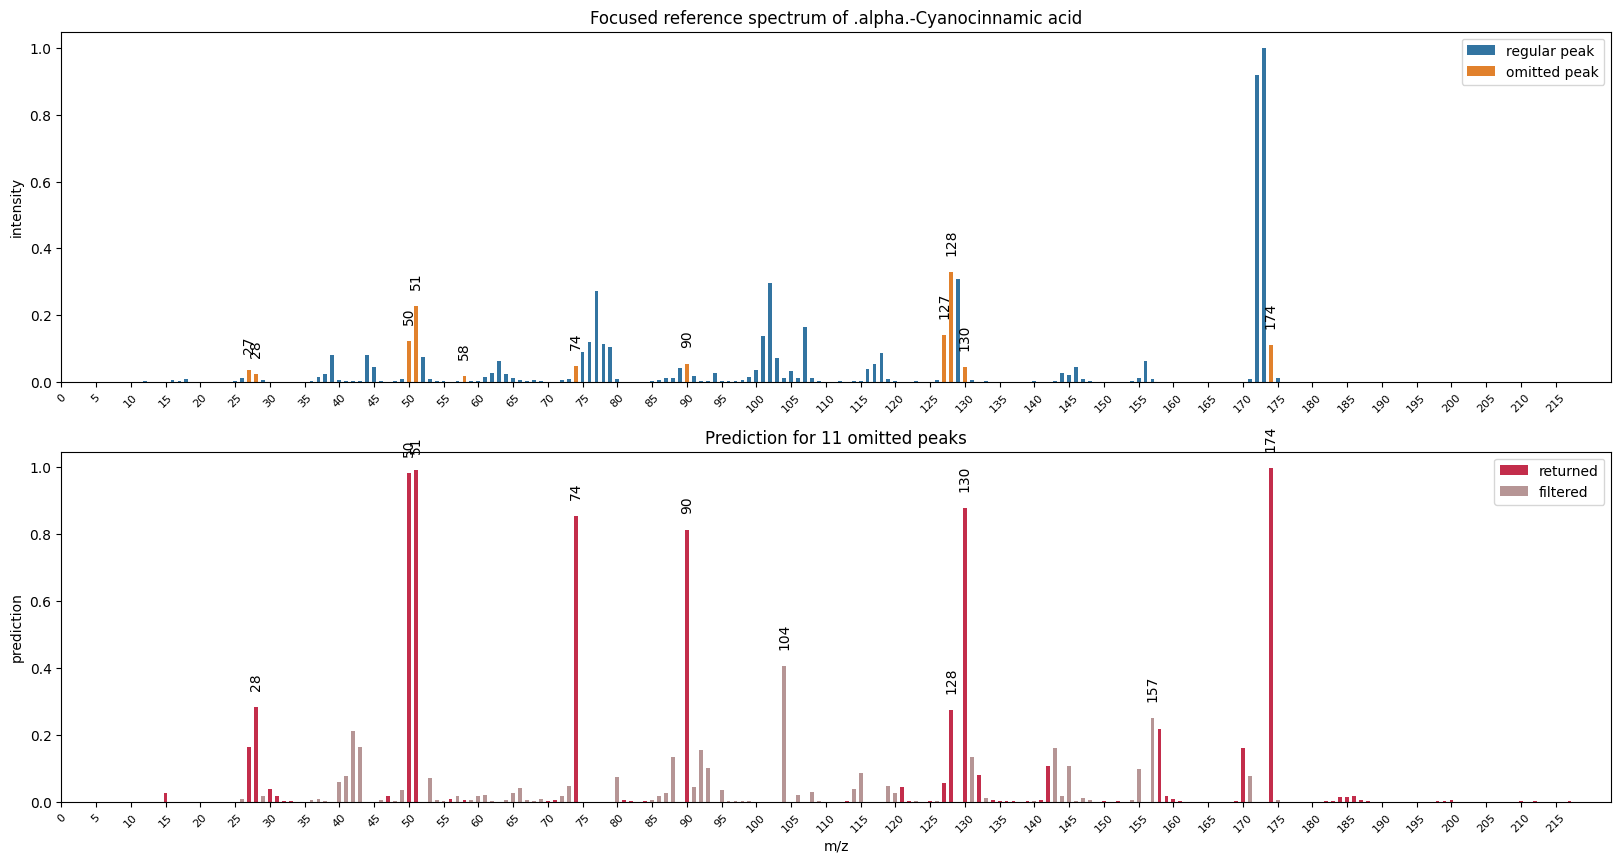

In [195]:
i  = 4444
datasets["fixed_val"].reset_rng(42)
X, y = datasets["fixed_val"][i]
pred = predictor(X).cpu().numpy()
plot_spectrum_predictions_random(documents_val[i], np.where(y!=0)[0], pred, \
                                 BasicCoder(max_mz=predictor.max_mz), plot_full=False, \
                                 save_to_path=f"figures/{kind}/visual/mlp_1_val.pdf")


## Model Selection
done on the val set

In [196]:
P_FOLDER = f"predictions/{kind}"
probs = [0, .01, .03, .05, .08, .1, .15, .2, .3, .5]

In [197]:
import os
from metrics import metrics_klj, metrics_intlj

predictors = { 
            "mlp_1_.8": PredictorFF.from_file(f"models/{kind}/mlp_1", max_mz=1001, device=device, threshold=.8),
            "mlp_1_.5": PredictorFF.from_file(f"models/{kind}/mlp_1", max_mz=1001, device=device, threshold=.5),
            "mlp_1_.3": PredictorFF.from_file(f"models/{kind}/mlp_1", max_mz=1001, device=device, threshold=.3),
            "mlp_1_.1": PredictorFF.from_file(f"models/{kind}/mlp_1", max_mz=1001, device=device, threshold=.1),
            "mlp_2_.8": PredictorFF.from_file(f"models/{kind}/mlp_2", max_mz=1001, device=device, threshold=.8),
            "mlp_2_.5": PredictorFF.from_file(f"models/{kind}/mlp_2", max_mz=1001, device=device, threshold=.5),
            "mlp_2_.3": PredictorFF.from_file(f"models/{kind}/mlp_2", max_mz=1001, device=device, threshold=.3),
            "mlp_2_.1": PredictorFF.from_file(f"models/{kind}/mlp_2", max_mz=1001, device=device, threshold=.1),
            "mlp_2s_.8": PredictorFF.from_file(f"models/{kind}/mlp_2s", max_mz=1001, device=device, threshold=.8),
            "mlp_2s_.5": PredictorFF.from_file(f"models/{kind}/mlp_2s", max_mz=1001, device=device, threshold=.5),
            "mlp_2s_.3": PredictorFF.from_file(f"models/{kind}/mlp_2s", max_mz=1001, device=device, threshold=.3),
            "mlp_2s_.1": PredictorFF.from_file(f"models/{kind}/mlp_2s", max_mz=1001, device=device, threshold=.1)


}


In [198]:
P_FOLDER

'predictions/de_novo'

In [199]:
from model_evaluation import calc_predictions_random, load_predictions_random, model_selection_random
from visual_utils import plot_scores

In [61]:
%%time
calc_predictions_random(probs, predictors, datasets, "fixed_val", P_FOLDER, batch_size=512, device=device, verbose=True)

mlp_1_.8


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


mlp_1_.5
mlp_1_.3
mlp_1_.1
mlp_2_.8
mlp_2_.5
mlp_2_.3
mlp_2_.1
mlp_2s_.8
mlp_2s_.5
mlp_2s_.3
mlp_2s_.1
CPU times: user 7min 50s, sys: 1.19 s, total: 7min 52s
Wall time: 7min 55s


In [200]:
best_p_name, scores = model_selection_random(P_FOLDER, "fixed_val", predictors=predictors)

mlp_2_.3


/mnt/storage-brno6/home/xstary1/raims/metrics.py:200: RuntimeWarning: Mean of empty slice
  mean_rec_some = np.nanmean(recs_some, axis=1)
/mnt/storage-brno6/home/xstary1/raims/metrics.py:202: RuntimeWarning: Mean of empty slice
  mean_f1_some = np.nanmean(f1_some, axis=1)
/mnt/storage-brno6/home/xstary1/raims/metrics.py:203: RuntimeWarning: Mean of empty slice
  mean_prec= np.nanmean(precs_m, axis=1)


mlp_2_.1
mlp_2s_.1
mlp_1_.1
mlp_1_.3
mlp_1_.5
mlp_2s_.5
mlp_1_.8
mlp_2_.8
mlp_2_.5
mlp_2s_.8
mlp_2s_.3


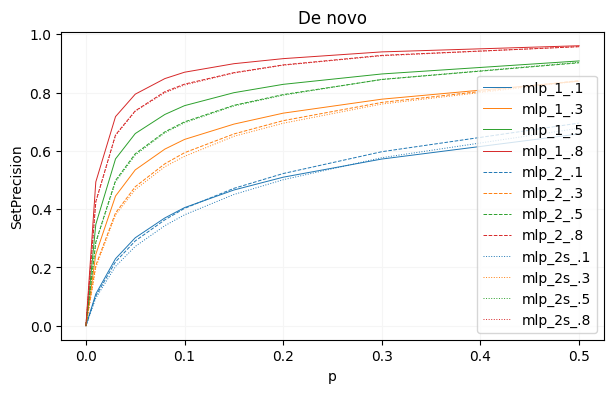

In [201]:
orderer_f = lambda x: (x.split("_")[1], x.split("_")[2][1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[2][1]))
plot_scores(scores, metrics="mp", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanPrecision",
            save_to_path=f"figures/{kind}/selection/mlp_val_prec.pdf")

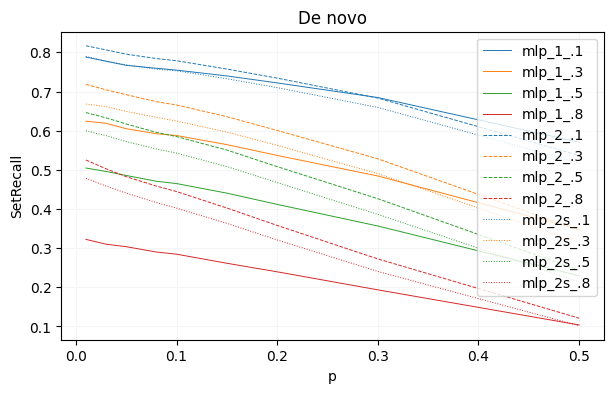

In [202]:
plot_scores(scores, metrics="mr", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanRecall",
            save_to_path=f"figures/{kind}/selection/mlp_val_rec.pdf")

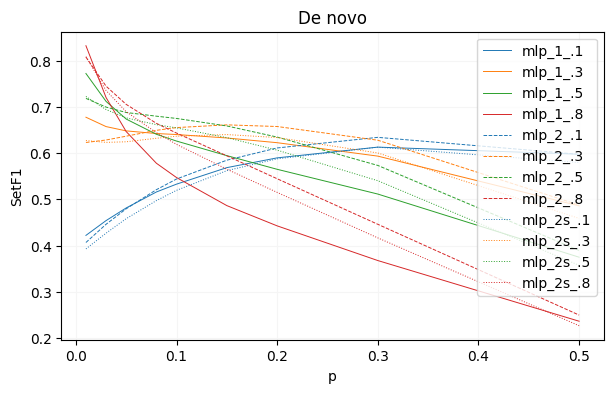

In [203]:

plot_scores(scores, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1",
            save_to_path=f"figures/{kind}/selection/mlp_val.pdf"
           )



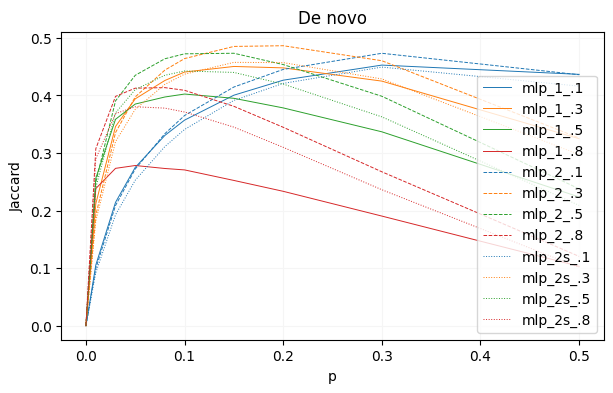

In [204]:
plot_scores(scores, metrics="mj", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanJaccard",
            save_to_path=f"figures/{kind}/selection/mlp_val_jac.pdf"
           )


In [205]:
scores

{'mlp_2_.3': {'mpm': array([       nan, 0.60489407, 0.61198676, 0.62015515, 0.62797786,
         0.6358127 , 0.64152379, 0.64338369, 0.64288091, 0.61657898]),
  'mp': array([0.        , 0.20706327, 0.38706107, 0.47696333, 0.55560545,
         0.59376411, 0.65796352, 0.70366117, 0.76618518, 0.84134589]),
  'mr': array([       nan, 0.71831919, 0.70435772, 0.69195117, 0.67396306,
         0.66565819, 0.63576676, 0.6005899 , 0.52823479, 0.34614836]),
  'mf1': array([       nan, 0.62288462, 0.62823102, 0.63646889, 0.64916489,
         0.65506218, 0.66097654, 0.65739672, 0.62774902, 0.48758006]),
  'mj': array([0.        , 0.19206518, 0.33546089, 0.39742521, 0.44394243,
         0.46398629, 0.48508533, 0.48630857, 0.46024563, 0.32604149])},
 'mlp_2_.1': {'mpm': array([       nan, 0.60489407, 0.61198676, 0.62015515, 0.62797786,
         0.6358127 , 0.64152379, 0.64338369, 0.64288091, 0.61657898]),
  'mp': array([0.        , 0.10176463, 0.21921209, 0.29093431, 0.36346355,
         0.40268501, 

In [206]:
best_p_name

'mlp_2_.5'

## Visualisation of the best predictor

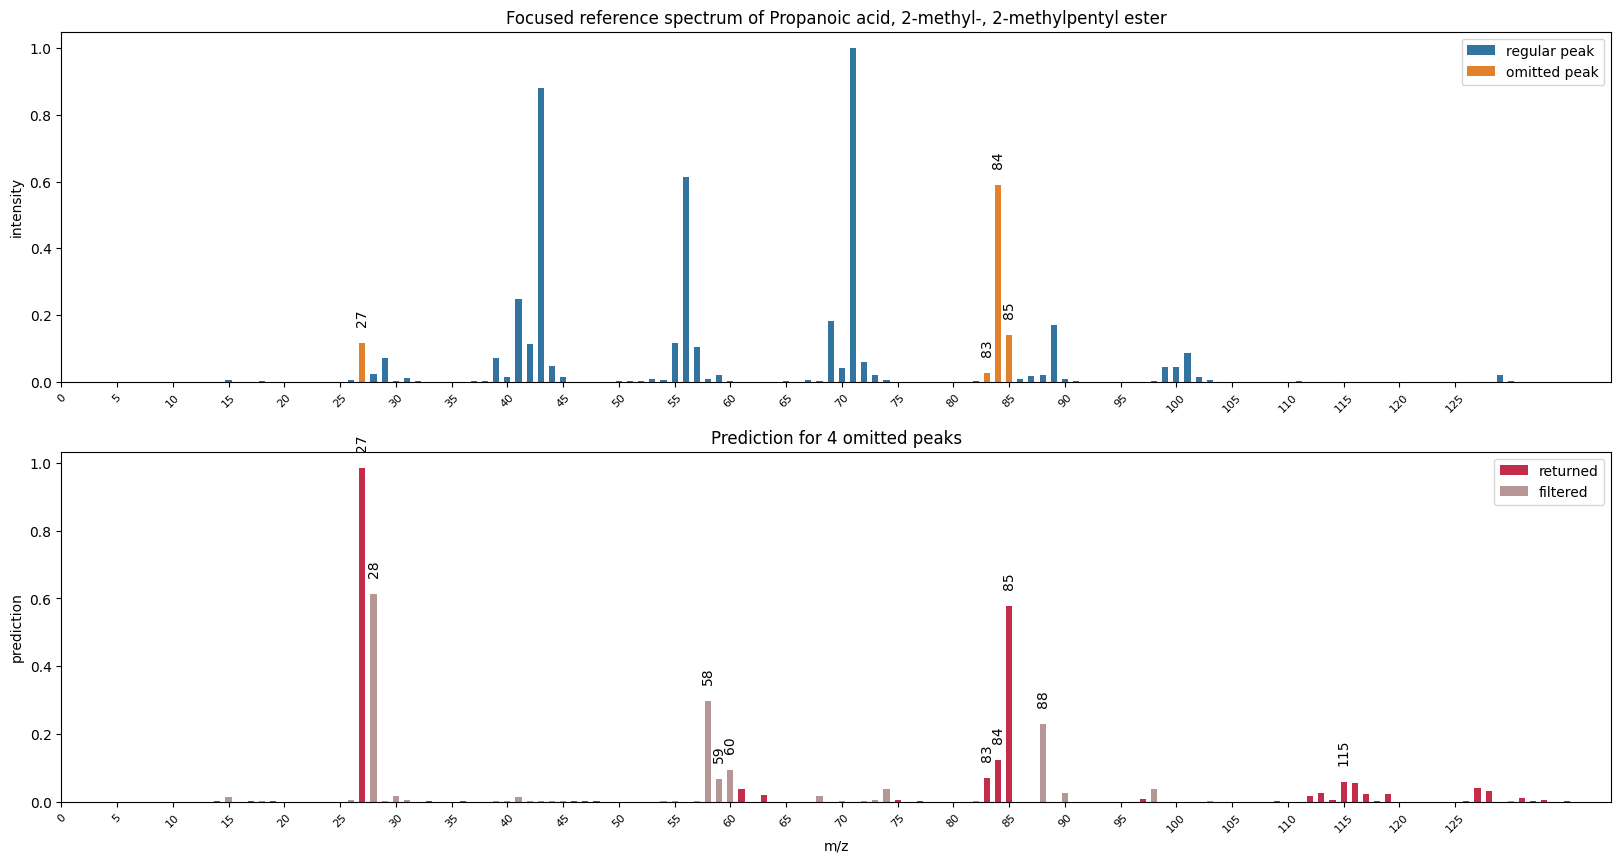

In [207]:
i  = 4444
datasets["fixed_test"].reset_rng(42)
X, y = datasets["fixed_test"][i]
pred = predictors[best_p_name](X.to(device)).cpu().numpy()
plot_spectrum_predictions_random(documents_test[i], np.where(y!=0)[0], pred, \
                                 BasicCoder(max_mz=predictors[best_p_name].max_mz), plot_full=False, \
                                save_to_path=f"figures/{kind}/visual/mlp_best_test.pdf")

